# Potential coastal flood impacts

## Risk assessment methodology

Below we consider the potential impacts of coastal flooding caused by extreme water levels. The methodology of calculating the flood risk is similar to that of the river flooding workflow (link). The flood risk is calculated as a combination of flood maps and economic damage functions. The flood maps are considered for two scenarios (present and 2050 under RCP8.5 climate scenario), and for different return periods.

The following datasets are used as input for the calculations:

- Flood maps: the maps of flood depth and extent are based on the Global Flood Maps dataset openly available via the Microsoft Planetary Computer ([link to dataset](https://planetarycomputer.microsoft.com/dataset/deltares-floods)). In this dataset, maps for present (ca. 2018) and future (ca. 2050) scenarios are available, with extreme water levels corresponding to return periods of 2, 5, 10, 25, 50, 100 and 250 years. The 2050 scenario includes the effect of sea level rise as estimated under RCP8.5 (high-emission scenario). The flood maps have a resolution of 3 arcseconds (30-75 m in European geographical area, depending on latitude).
- Land-use information: The land cover map is available from the [Copernicus Land Monitoring Service](https://land.copernicus.eu/pan-european/corine-land-cover)   
- Flood damage: translated based on flood inundation depth using damage curves (available [here](https://publications.jrc.ec.europa.eu/repository/handle/JRC105688). For each grid point, the inundation depth is used to assess the damage, based on the land use type and country-specific parameters that can be defined by the user.   


## Technical description of the considered flood map dataset and its limitations

(#TODO: to write up the description based on points below)

GTSM, ERA5
bathtub inundation modelling with attenuation correction over land
MERIT DEM, NASADEM
SLR from IPCC AR5
The effect of climate change is accounted for by superimposing sea level rise on the water level values (KNMI).

Coastal resolution of GTSM is high on global scale, but for local areas with complex bathymetry it may be too coarse (e.g. estuaries or semi-enclosed bays).
This dataset helps to understand the flood potential at a location. It does not include the protective effect of existing man-made coastal protections (e.g. dams, storm barriers). 
For a more accurate estimate of risks, it is recommended to perform local flood modelling, taking the results of global models as boundary conditions. Local models can take better account of complex bathymetry and topography, and incorporate local data and knowledge.

## Preparation work

### Load libraries
In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - A data retrieval and storage utility that simplifies downloading and managing datasets.
- [numpy](https://numpy.org/): A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/): A data manipulation and analysis library, essential for working with structured data in tabular form.
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - A library for reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data in GeoTIFF format.
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - A library designed for calculating flood damages based on geospatial data, particularly suited for analyzing flood impact.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/) A library for adding basemaps to plots, enhancing geospatial visualizations.
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) A library for geospatial data processing.

- [planetary-computer](https://pypi.org/project/planetary-computer/) A library for interacting with the Microsoft Planetary Computer.
- [dask](https://www.dask.org/) A library for parallel computing and task scheduling.
- [pystac-client](https://pystac-client.readthedocs.io/en/stable/) A library for for working with STAC Catalogs and APIs.
- [shapely](https://shapely.readthedocs.io/en/stable/index.html) A library for manipulation and analysis of geometric objects.

These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data.

In [1]:
# Package for downloading data and managing files
import os
import pooch
import dask.distributed
import pystac_client
import planetary_computer

# Packages for working with numerical data and tables
import numpy as np
import pandas as pd

# Packages for handling geospatial maps and data
import rioxarray as rxr
from rioxarray.merge import merge_datasets
import xarray as xr
import rasterio
from rasterio.enums import Resampling

# Package for calculating flood damages
from damagescanner.core import RasterScanner

# Ppackages used for plotting maps
import matplotlib.pyplot as plt
import contextily as ctx
import shapely.geometry
import cartopy.feature as cfeature
import cartopy.crs as ccrs


### Create the directory structure

In [2]:
# Define the folder for the flood workflow
workflow_folder = 'coastal_flood_workflow'

# Check if the workflow folder exists, if not, create it along with subfolders for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(workflow_folder, 'data'))
    os.makedirs(os.path.join(workflow_folder, 'results'))

In [3]:
# Define directories for data and results within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, 'data')
results_dir = os.path.join(workflow_folder, 'results')

# Select area of interest
Before downloading the data, we will define the coordinates of the area of interest. Based on these coordinates we will be able to clip the datasets for further processing, and eventually display hazard and damage maps for the selected area.

To easily define an area in terms of geographical coordinates, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the coordinates. Make sure to select 'CSV' in the lower left corner and copy the values in the brackets below. Next to coordinates, please specify a name for the area which will be used in plots and saved results.

In [4]:
bbox = [-2.94,51.4,-2.5,51.7] 
areaname = 'Bristol'

#bbox = [1.983871,41.252461,2.270614,41.449569]; areaname = 'Barcelona'
#bbox = [-1.6,46,-1.05,46.4]; areaname = 'La_Rochelle'
#bbox = [12.1,45.1,12.6,45.7]; areaname = 'Venice'

# Download data

## Flood map data

We will use the potential coastal flood depth maps from the [Deltares Global Flood Maps dataset](https://planetarycomputer.microsoft.com/dataset/deltares-floods). This dataset is accessible remotely via API. Below we will first explore an example of a flood map from the dataset, and then load a subset of this dataset for our area of interest.

In [5]:
# prepare to connect to server 
client = dask.distributed.Client(processes=False)
print(client.dashboard_link)

http://192.168.178.80:8787/status


In [6]:
# establish connection and search for floodmaps
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["deltares-floods"],
    query={
        "deltares:dem_name": {"eq": "MERITDEM"},         # option to select the underlying DEM (MERITDEM or NASADEM)
        "deltares:resolution": {"eq": '90m'}})           # option to select resolution (recommended: 90m)

# Print the all found items: 
#for item in search.items():
#    print(item.id)

# Print the first item 
print(next(search.items()))

# count the number of items
items = list(search.items())
print("Number of items found: ",len(items))

<Item id=MERITDEM-90m-2050-0250>
Number of items found:  16


In the cell above connection to the server was made and a list of all items that match our search is retrieved. Here the search was restricted to one Digital Elevation Model (MERIT-DEM) with high-resolution maps (90 m). 
The first item of the list was printed to check correctness of the search. Items IDs are in the format of *{DEM name}-{resolution}-{year}-{return period}*.
The total number of records is also printed, which includes all available combinations of scenarios and return periods.

Now we will select the first item as an example and process it to view the flood map.

In [55]:
# select first item from the search and open the dataset 
item = next(search.items())
url = item.assets["index"].href
ds = xr.open_dataset(f"reference::{url}", engine="zarr", consolidated=False, chunks={})

We have opened the first dataset. The extent of the dataset is global, therefore the number of points along latitude and longitude axes is very large. This dataset needs to be clipped to our area of interest, reprojected to local coordinates. 

We can view the contents of the raw dataset:

In [56]:
print(ds)

<xarray.Dataset>
Dimensions:     (time: 1, lat: 216000, lon: 432000)
Coordinates:
  * lat         (lat) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * lon         (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time        (time) datetime64[ns] 2010-01-01
Data variables:
    inun        (time, lat, lon) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    projection  object ...
Attributes:
    Conventions:  CF-1.6
    config_file:  /mnt/globalRuns/watermask_post_MERIT/run_rp0250_slr2050/coa...
    institution:  Deltares
    project:      Microsoft Planetary Computer - Global Flood Maps
    references:   https://www.deltares.nl/en/
    source:       Global Tide and Surge Model v3.0 - ERA5
    title:        GFM - MERIT DEM 90m - 2050 slr - 0250-year return level


Now we will clip the dataset to a wider area around the region of interest, and call it *ds_local*. The extra margin is added to account for reprojection at a later stage. The clipping of the dataset allows to reduce the total size of the dataset so that it can be loaded into memory for faster processing and plotting.

In [57]:
ds_local = ds.sel(lat=slice(bbox[1]-0.5,bbox[3]+0.5), lon=slice(bbox[0]-0.5,bbox[2]+0.5),drop=True).squeeze(); del ds
ds_local.load()

<xarray.Dataset>
Dimensions:     (lat: 1561, lon: 1728)
Coordinates:
  * lat         (lat) float64 50.9 50.9 50.9 50.9 50.9 ... 52.2 52.2 52.2 52.2
  * lon         (lon) float64 -3.439 -3.438 -3.438 -3.437 ... -2.002 -2.001 -2.0
    time        datetime64[ns] 2010-01-01
Data variables:
    inun        (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    projection  object nan
Attributes:
    Conventions:  CF-1.6
    config_file:  /mnt/globalRuns/watermask_post_MERIT/run_rp0250_slr2050/coa...
    institution:  Deltares
    project:      Microsoft Planetary Computer - Global Flood Maps
    references:   https://www.deltares.nl/en/
    source:       Global Tide and Surge Model v3.0 - ERA5
    title:        GFM - MERIT DEM 90m - 2050 slr - 0250-year return level

We will convert the dataset to a geospatial array, drop the unnecessary coordinates, reproject the array to the projected coordinate system for Europe, and, finally, clip it to the region of interest using our bounding box. 

In [58]:
ds_local.rio.write_crs(ds_local.projection.EPSG_code, inplace=True)
ds_local = ds_local.drop_vars({"projection","time"})
ds_local = ds_local.rio.reproject("epsg:3035")
ds_local = ds_local.rio.clip_box(*bbox, crs="EPSG:4326")

We can now plot the dataset to see the flood map for one scenario and return period: 

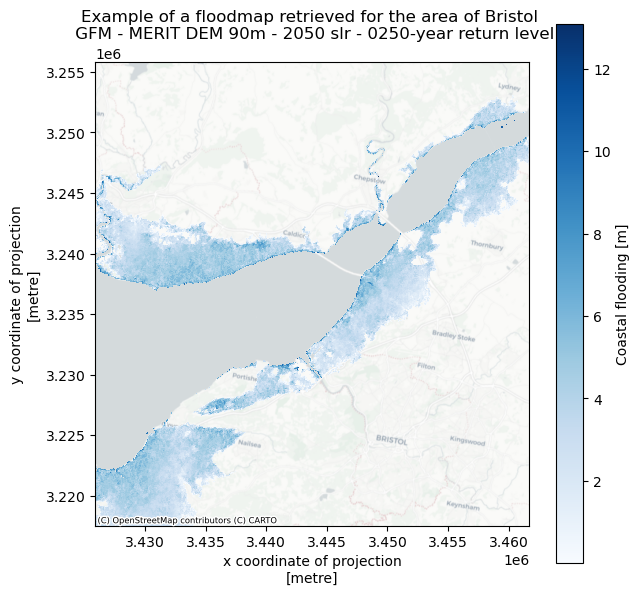

In [67]:
fig, ax = plt.subplots(figsize=(7, 7))
bs=ds_local.where(ds_local.inun>0)['inun'].plot(ax=ax,cmap='Blues',alpha=1)
ctx.add_basemap(ax=ax,crs='EPSG:3035',source=ctx.providers.CartoDB.Positron, attribution_size=6)
plt.title(f'Example of a floodmap retrieved for the area of {areaname} \n {ds_local.attrs["title"]}',fontsize=12);

We would like to be able to compare the flood maps for different scenarios and return periods. For this, we will load and merge the datasets for different scenarios and return periods in one dataset, where the flood maps can be easily accessed. Below a function is defined which contains the steps described above for an individual dataset. 

In [68]:
# combine the above steps into a function to load flood maps per year and return period
def load_floodmaps(catalog,year,rp):
    search = catalog.search(
    collections=["deltares-floods"],
    query={
        "deltares:dem_name": {"eq": "MERITDEM"},     
        "deltares:resolution": {"eq": '90m'},           
        "deltares:sea_level_year": {"eq": year}, 
        "deltares:return_period": {"eq": rp}})     
    item=next(search.items())
    url = item.assets["index"].href
    ds = xr.open_dataset(f"reference::{url}", engine="zarr", consolidated=False, chunks={})
    ds_local = ds.sel(lat=slice(bbox[1]-0.5,bbox[3]+0.5), lon=slice(bbox[0]-0.5,bbox[2]+0.5),drop=True).squeeze(); del ds
    ds_local.rio.write_crs(ds_local.projection.EPSG_code, inplace=True)
    ds_local = ds_local.drop_vars({"projection","time"})
    ds_local = ds_local.rio.reproject("epsg:3035")
    ds_local = ds_local.rio.clip_box(*bbox, crs="EPSG:4326")
    ds_local.load()
    ds_local = ds_local.assign_coords(year=year); ds_local = ds_local.expand_dims('year') # write corresponding scenario year in the dataset coordinates
    ds_local = ds_local.assign_coords(return_period=rp); ds_local = ds_local.expand_dims('return_period') # write corresponding return period in the dataset coordinates
    ds_floodmap = ds_local.where(ds_local.inun > 0)
    return ds_floodmap

We can now apply this function, looping over the two scenarios and a selection of return periods. 

In the Global Flood Maps dataset there are two scenarios: Present (represented by the year 2018) and Future (the year 2050, where sea level rise corresponding to the high-emission scenario, RCP8.5, is assumed).
The available return periods range between 2 years and 250 years. Below we use a selection that includes 5, 10, 50, 100-year return periods).

In [72]:
# load all floodmaps in one dataset
years = [2018,2050] # list of scenario years (2018 and 2050)
rps = [2,5,10,50,100,250] # list of return periods (all: 2,5,10,25,50,100,250 yrs)
for year in years: 
    for rp in rps: 
        ds = load_floodmaps(catalog,year,rp)
        if (year==years[0]) & (rp==rps[0]):
            floodmaps = ds
        else:
            floodmaps = xr.merge([floodmaps,ds],combine_attrs="drop_conflicts")
        del ds        

The *floodmaps* variable now contains the flood maps for different years and scenarios. We can view the contents of the variable:

In [73]:
print(floodmaps)

<xarray.Dataset>
Dimensions:        (x: 474, y: 506, year: 2, return_period: 6)
Coordinates:
  * x              (x) float64 3.426e+06 3.426e+06 ... 3.462e+06 3.462e+06
  * y              (y) float64 3.256e+06 3.256e+06 ... 3.218e+06 3.218e+06
  * year           (year) int32 2018 2050
  * return_period  (return_period) int32 2 5 10 50 100 250
    spatial_ref    int32 0
Data variables:
    inun           (return_period, year, y, x) float32 nan nan nan ... nan nan
Attributes:
    Conventions:  CF-1.6
    institution:  Deltares
    project:      Microsoft Planetary Computer - Global Flood Maps
    references:   https://www.deltares.nl/en/
    source:       Global Tide and Surge Model v3.0 - ERA5


We will use the dataset in the *floodmaps* variable later on in this workflow to calculate flood risk.

## Land-use information

Next we need the information on land use.  We will download the land use dataset from the JRC data portal, a copy of the dataset will be saved locally for ease of access.

In [ ]:
# Define the URL for the LUISA basemap and download it using Pooch
luisa_filename = 'LUISA_basemap_020321_100m.tif'

In [76]:
url = 'http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/EUROPE/Basemaps/2018/VER2021-03-24/LUISA_basemap_020321_100m.tif'
pooch.retrieve(
    url=url,
    known_hash=None,  # Hash value is not provided
    path=data_dir,    # Save the file to the specified data directory
    fname=luisa_filename  # Save the file with a specific name
)

'C:\\Users\\aleksand\\OneDrive - Stichting Deltares\\Documents\\git_checkouts\\CLIMAAX\\FLOODS\\coastal_flood_workflow\\data\\LUISA_basemap_020321_100m.tif'

The Land use data is extracted into the local data directory. The data shows on a 50 by 50 meter resolution what the land use is for Europe in 2018. The land use encompasses various types of urban areas, natural land, agricultural fields, infrastructure and waterbodies. This will be used as the exposure layer in the risk assessment.

In [80]:
# Define the filename for the land use map based on the specified data directory
filename_land_use = f'{data_dir}/{luisa_filename}'

# Open the land use map raster using rioxarray
land_use = rxr.open_rasterio(filename_land_use)

# Display the opened land use map
print(land_use)

<xarray.DataArray (band: 1, y: 46000, x: 65000)>
[2990000000 values with dtype=int32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0


The land use dataset needs to be clipped to the area of interest. For visualization purposes, each land use type is then assigned a color. Land use plot shows us the variation in land use over the area of interest.

In [92]:
# Set the coordinate reference system (CRS) for the land use map to EPSG:3035
land_use.rio.write_crs(3035, inplace=True)

# Clip the land use map to the specified bounding box and CRS
land_use_local = land_use.rio.clip_box(*bbox, crs="EPSG:4326")

# Save the clipped land use map
with rasterio.open(
    f'{data_dir}/land_use_local.tif',
    'w',
    driver='GTiff',
    height=land_use_.shape[1],
    width=land_use_.shape[2],
    count=1,
    dtype=str(land_use_local.dtype),
    crs=land_use_local.rio.crs,
    transform=land_use_local.rio.transform()
) as dst:
    # Write the data array values to the rasterio dataset
    dst.write(land_use_local.values)

Text(0.5, 1.0, 'LUISA Land Cover for the defined area')

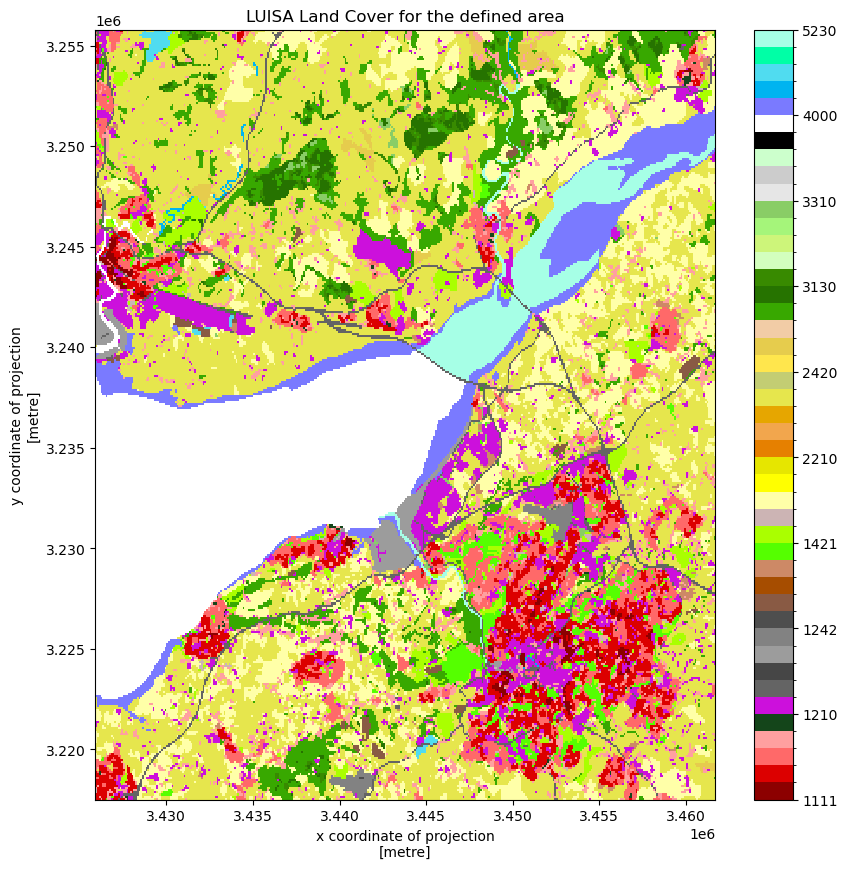

In [85]:
# Plotting

# Define values and colors for different land use classes
LUISA_values = [1111, 1121, 1122, 1123, 1130,
                1210, 1221, 1222, 1230, 1241,
                1242, 1310, 1320, 1330, 1410,
                1421, 1422, 2110, 2120, 2130,
                2210, 2220, 2230, 2310, 2410,
                2420, 2430, 2440, 3110, 3120,
                3130, 3210, 3220, 3230, 3240,
                3310, 3320, 3330, 3340, 3350,
                4000, 5110, 5120, 5210, 5220,
                5230]

LUISA_colors = ["#8c0000", "#dc0000", "#ff6969", "#ffa0a0", "#14451a",
                "#cc10dc", "#646464", "#464646", "#9c9c9c", "#828282",
                "#4e4e4e", "#895a44", "#a64d00", "#cd8966", "#55ff00",
                "#aaff00", "#ccb4b4", "#ffffa8", "#ffff00", "#e6e600",
                "#e68000", "#f2a64d", "#e6a600", "#e6e64d", "#c3cd73",
                "#ffe64d", "#e6cc4d", "#f2cca6", "#38a800", "#267300",
                "#388a00", "#d3ffbe", "#cdf57a", "#a5f57a", "#89cd66",
                "#e6e6e6", "#cccccc", "#ccffcc", "#000000", "#ffffff",
                "#7a7aff", "#00b4f0", "#50dcf0", "#00ffa6", "#a6ffe6",
                "#e6f2ff"]

# Plot the land use map using custom levels and colors
land_use_local.plot(levels=LUISA_values, colors=LUISA_colors, figsize=(10, 10))

# Set the title for the plot
plt.title('LUISA Land Cover for the defined area')

## Damage curves

We will use damage curve files from the JRC.

Text(0, 0.5, 'Damage ratio [%]')

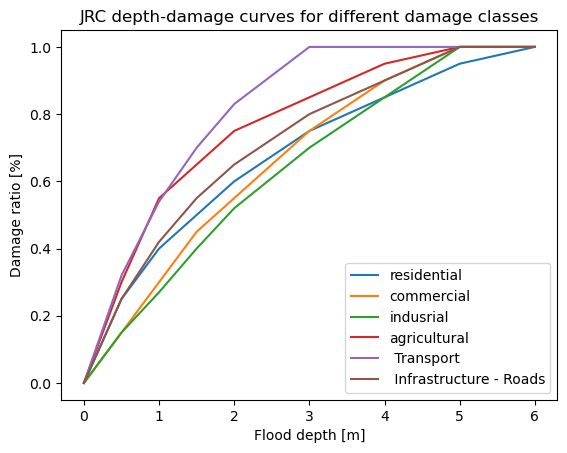

In [97]:
# Import damage curves of the JRC from a CSV file into a pandas DataFrame
JRC_curves = pd.read_csv('JRC_damage_curves.csv', index_col=0)

# Plot the JRC depth-damage curves
JRC_curves.plot()

# Set the title and labels for the plot
plt.title('JRC depth-damage curves for different damage classes')
plt.xlabel('Flood depth [m]')
plt.ylabel('Damage ratio [%]')

# Processing data: from hazard to risk

The maps of flooding and land use can be combined to assess multipe types of risk from coastal flooding in a region. This way we can estimate the exposure of population, infrastructure and economic assets to coastal floods. Different methods exist for translating hazard maps to risk estimations. In this workflow we will look into estimating the potential economic damages.

## Combining datasets with different resolution
The flood and land use datasets have different spatial resolutions. Flood extent maps are at a resolution of 30-75 m (resolution varies with latitude), while land use data is at a constant 50 m resolution. We can bring them to the same resolution.  
Both grids have a similar resolution, but it is preferable to interpolate the flood map onto the land use grid, because land use is defined in terms of discrete values and on a more convenient regularly spaced grid. We will interpolate the flood data onto the land use map grid in order to be able to calculate the damages.   

In [86]:
# Reproject the flood map to match the resolution and extent of the land use map
for year in years:
    for rp in rps:
        ori_map = floodmaps['inun'].sel(year=year,return_period=rp)
        new_map = ori_map.rio.reproject_match(land_use_local, resampling=Resampling.bilinear); del ori_map
        ds = new_map.to_dataset(); del new_map
        ds = ds.expand_dims(dim={'year':1,'return_period':1})

        if (year==years[0]) & (rp==rps[0]):
            floodmaps_resampled = ds
        else:
            floodmaps_resampled = floodmaps_resampled.merge(ds)

In [88]:
# check the new resolution of the floodmap
floodmaps_resampled.rio.resolution()

(100.0, -100.0)

We will save the resampled flood maps in raster format locally, so that DamageScanner package can use them as input to calculate economic damages.

In [90]:
# Create GeoTIFF files for the resampled flood maps
tif_dir = os.path.join(data_dir,'floodmap_plots_resampled_tif')
if not os.path.isdir(tif_dir): os.makedirs(tif_dir)

In [ ]:
for year in years:
    for rp in rps:
        data_tif = floodmaps_resampled['inun'].sel(year=year,return_period=rp,drop=True)
        with rasterio.open(
            f'{tif_dir}/floodmap_resampled_{areaname}_{year}_rp{rp:04d}.tif',  
            'w',
            driver='GTiff',
            height=data_tif.shape[0],
            width=data_tif.shape[1],
            count=1,                    
            dtype=str(data_tif.dtype),
            crs=data_tif.rio.crs,
            transform=data_tif.rio.transform(),
        ) as dst:
            # Write the data array values to the rasterio dataset
            dst.write(data_tif.values,indexes=1)

### Linking land use types to economic damages

In order to assess the potential damage done by the flooding in a given scenario, we also need to assign a monetary value to the land use categories. We define this as the potential loss in €/m². Go into the provided **LUISA_damage_info_curves.xlsx** and tweak the information to your own region.

In [95]:
# Read damage curve information from an Excel file into a pandas DataFrame
LUISA_info_damage_curve = pd.read_excel('LUISA_damage_info_curves.xlsx', index_col=0)

# Extract the 'total €/m²' column to get the maximum damage for reconstruction
maxdam = pd.DataFrame(LUISA_info_damage_curve['total €/m²'])

# Save the maximum damage values to a CSV file
maxdam.to_csv(f'{data_dir}/maxdam_luisa.csv')

# Display the first 10 rows of the resulting DataFrame to view the result
maxdam.head(10)

,total €/m²
Land use code,
1111,600.269784
1121,414.499401
1122,245.022999
1123,69.919184
1130,0.000000
1210,405.238393
1221,40.417363
1222,565.843080
1230,242.504177


Text(0.5, 0, 'Inundation depth (m)')

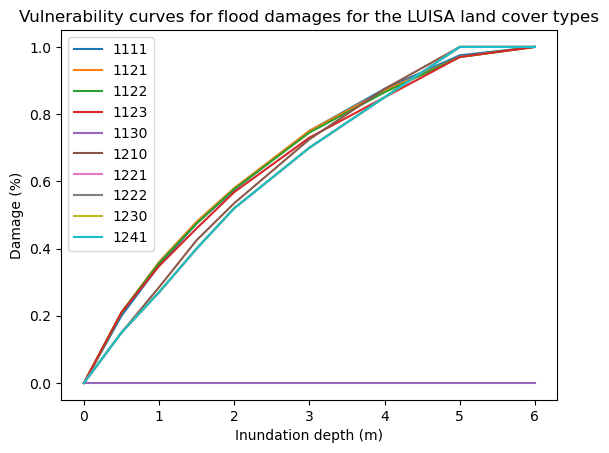

In [98]:
# Create a new DataFrame for damage_curves_luisa by copying JRC_curves
damage_curves_luisa = JRC_curves.copy()

# Drop all columns in the new DataFrame
damage_curves_luisa.drop(damage_curves_luisa.columns, axis=1, inplace=True)

# Define building types for consideration
building_types = ['residential', 'commercial', 'industrial']

# For each land use class in maxdamage, create a new damage curve
for landuse in maxdam.index:
    # Find the ratio of building types in the class
    ratio = LUISA_info_damage_curve.loc[landuse, building_types].values

    # Create a new curve based on the ratios and JRC_curves
    damage_curves_luisa[landuse] = ratio[0] * JRC_curves.iloc[:, 0] + \
                                   ratio[1] * JRC_curves.iloc[:, 1] + \
                                   ratio[2] * JRC_curves.iloc[:, 2]

# Save the resulting damage curves to a CSV file
damage_curves_luisa.to_csv(f'{data_dir}/curves.csv')    

# Plot the vulnerability curves for the first 10 land cover types
damage_curves_luisa.iloc[:, 0:10].plot()
plt.title('Vulnerability curves for flood damages for the LUISA land cover types')
plt.ylabel('Damage (%)')
plt.xlabel('Inundation depth (m)')


## Calculate potential damage using DamageScanner

Now that we have all pieces of the puzzle in place, we can perform the risk calculation. For this we are using the [DamageScanner](https://damagescanner.readthedocs.io/en/latest/index.html) python library which allows for an easy damage calculation. 

The DamageScanner takes the following data:
- The clipped and resampled flood map 
- The clipped landuse map
- The vulnerability curves per land use category
- A table of maximum damages per land use category 

We can perform a damage calculation for a specific year and return period. The selection can be made below:

In [ ]:
# Select scenario year and return period
year = 2018
rp = 250

In [ ]:
# Define file paths for the flood map, land use map, vulnerability curves, and maximum damages
inun_map = os.path.join(tif_dir, f'floodmap_resampled_Bristol_{year}_rp{rp:04}.tif')
landuse_map = os.path.join(data_dir, 'land_use_local.tif')
curve_path = os.path.join(data_dir, 'curves.csv')
maxdam_path = os.path.join(data_dir, 'maxdam_luisa.csv')

In [ ]:
# Do the damage calculation and save the results as 'flood_scenario'
loss_df = RasterScanner(landuse_map,
                        inun_map,
                        curve_path,
                        maxdam_path, 
                        save = True, 
                        nan_value = None, 
                        scenario_name= '{}/flood_scenario_{}_{}_rp{:04}'.format(results_dir,areaname,year,rp),
                        dtype = np.int64)

In [ ]:
# Obtain the LUISA legend and add it to the table of damages
LUISA_legend = LUISA_info_damage_curve['Description']

# Combine loss_df with LUISA_legend
category_damage = pd.concat([LUISA_legend, (loss_df[0])], axis=1)

# Convert the damages to million euros
category_damage['damage mln.'] = category_damage['damages'] / 10**6

# Drop the 'damages' column
category_damage.drop('damages', axis=1, inplace=True)

# Sort the values by damage in descending order
category_damage.sort_values(by='damage mln.', ascending=False, inplace=True)

# Display the resulting DataFrame (top 10 rows)
category_damage.head(10)


## Plot the results

Now we plot the damages to get a spatial view of what places can potentially be most affected economically.

In [ ]:
# Open a raster file representing flood damages for a specific scenario
damagemap = rxr.open_rasterio('{}/flood_scenario_{}_{}_rp{:04}_damagemap.tif'.format(results_dir,areaname,year,rp))

# Select values in the damagemap that are greater than 0
damagemap = damagemap.where(damagemap > 0)

# Create a plot with a specified size
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the damagemap with a color map representing damages and a color bar
damagemap.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Damage [€]"})

# Set plot title and labels for X and Y coordinates
plt.title('Coastal flood damages for extreme sea water level scenarios \n' + f'Year {year}, extreme water levels for 1 in {rp} year return period')
plt.xlabel('X coordinate in the projection')
plt.ylabel('Y coordinate in the projection')

# Add a basemap background to the plot using Contextily
ctx.add_basemap(ax=ax, crs=damagemap.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)

To get a better indication of why certain areas are damaged more than others, we also plot the floodmap and land use maps in one figure.

In [ ]:
fig, ([ax1, ax2, ax3]) = plt.subplots(figsize=(15, 5),nrows=1,ncols=3,sharex=True,sharey=True,layout='constrained')

# Plot flood damages on the first plot
damagemap.plot(ax=ax1, cmap='Reds', cbar_kwargs={'label': "Damage [€]",'pad':0.01,'shrink':0.95,'aspect':30})
ax1.set_title(f'Flood damages for 1 in {rp} year return period')
ax1.set_xlabel('X coordinate in the projection')
ax1.set_ylabel('Y coordinate in the projection')

# Plot inundation depth on the second plot
floodmaps_resampled.sel(year=year,return_period=rp)['inun'].plot(ax=ax2, cmap='Blues', cbar_kwargs={'label': "Inundation depth [m]",'pad':0.01,'shrink':0.95,'aspect':30})
ax2.set_title(f'Flood depth for 1 in {rp} year return period')
ax2.set_xlabel('X coordinate in the projection')
ax2.set_ylabel('Y coordinate in the projection')

# Plot land use on the third plot with custom colors
land_use_local.plot(ax=ax3, levels=LUISA_values, colors=LUISA_colors, cbar_kwargs={'label': "Land use class [-]",'pad':0.01,'shrink':0.95,'aspect':30})
ax3.set_title('LUISA Land Cover for the defined area')
ax3.set_xlabel('X coordinate in the projection')
ax3.set_ylabel('Y coordinate in the projection')

plt.suptitle('Flood maps for extreme sea water level scenarios in ' + f'Year {year}',fontsize=12)

# Add a map background to each plot using Contextily
ctx.add_basemap(ax1, crs=damagemap.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2, crs=floodmaps_resampled.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax3, crs=land_use_local.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Display the plot
plt.show()

fileout = os.path.join(results_dir,'Result_map_{}_{}_rp{:04}.png'.format(areaname,year,rp))
fig.savefig(fileout) 

Here we see both the the potential flood depths and the associated economic damages. 

Make sure to check the results and try to explain why high damages do or do not occur in case of high innundation. Find that something is wrong? Reiterate your assumptions made in the **LUISA_damage_info_curves.xlsx** and run the workflow again.

## Understanding accuracy of flood map damage calculations

## Understanding accuracy of the data sources
#TODO
Disclaimer about flood protection and infrastructure...
Disclaimer about maps being based on static "bathtub" method...

:::{important}

:::
